# Project 4: Question Answering on Squad
## CS4740/5740 Fall 2020




Name: Jennifer Russell


# Overview

---

In this project you will develop NLP models for question-answering tasks. Specifically, you will train models on the SQuAD 2.0 dataset which contains questions on text segments from Wikipedia. The dataset aims to measure the reading comprehension capabilities of machines. Some examples from the main paper are given below. For Project 4, the task is divided into two parts. First, you will decide on a model by yourself and train it on this task. Secondly, you will fine-tune a pretrained model. 




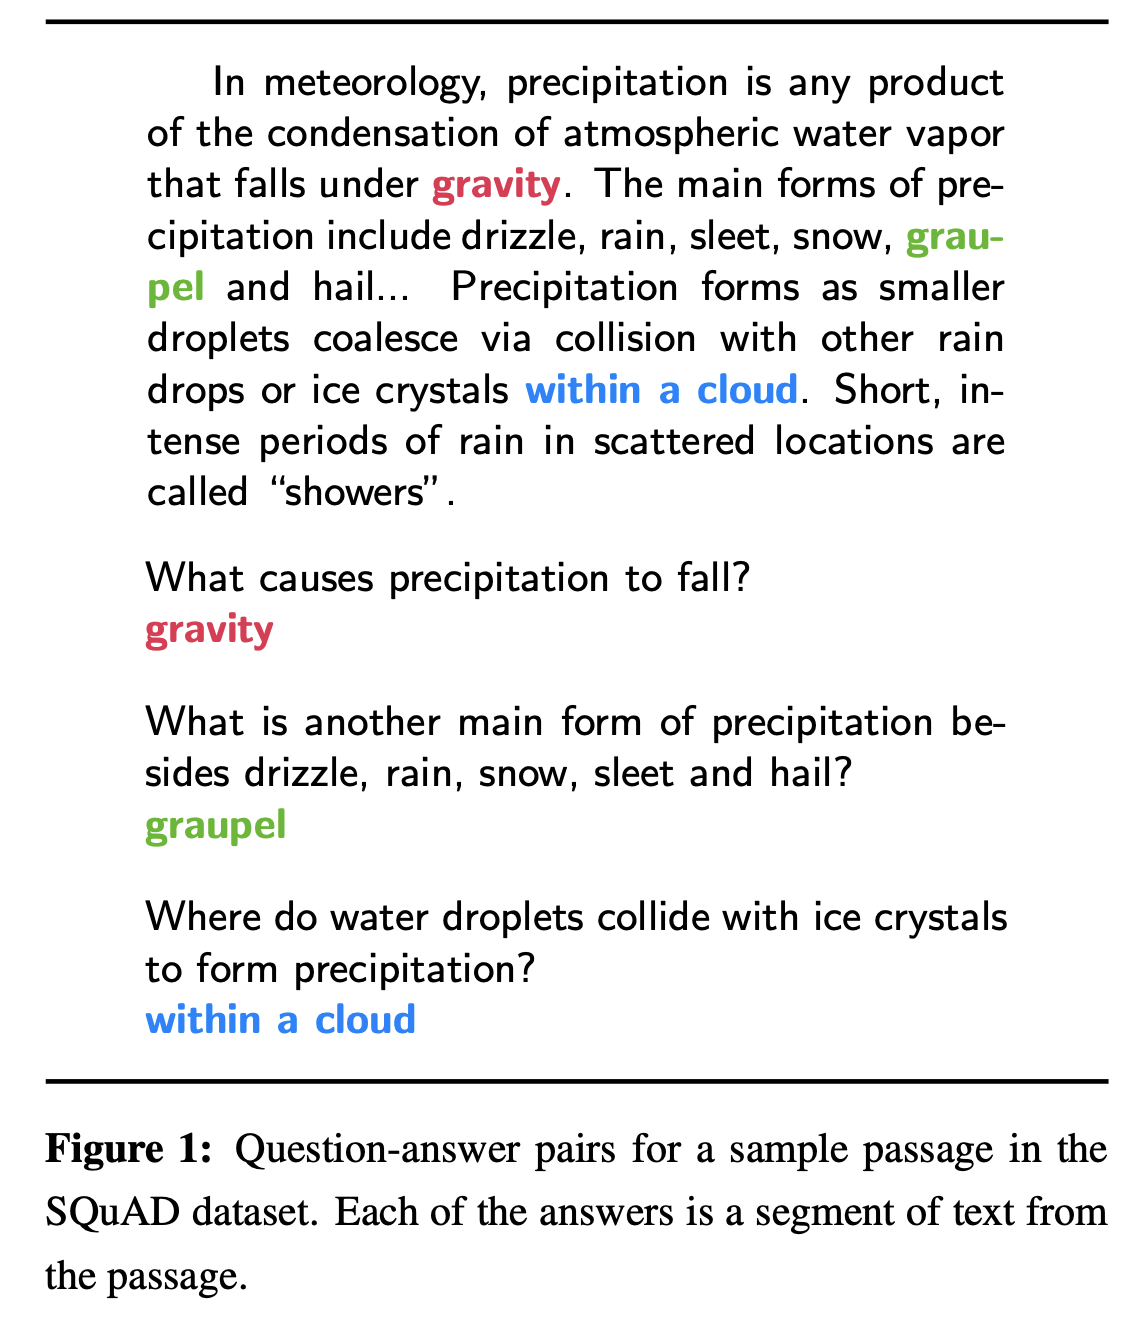

# Task and dataset

---

Obtain the data from [here](https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json). You also may consider doing so in a code block below.

```bash
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json
```

This gives you the dataset containing about 130,319 examples. You should split this into a **train** and **validation** dataset as in Project 2.


In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051304 sha256=a767a1a768f6a05c77f55b9a857ce3b4b5223498c03f1c46ba447c476e29fcf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6nkgoet/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json

--2020-12-20 15:21:27--  https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json
Resolving p4-squad-data.s3.us-east-2.amazonaws.com (p4-squad-data.s3.us-east-2.amazonaws.com)... 52.219.102.34
Connecting to p4-squad-data.s3.us-east-2.amazonaws.com (p4-squad-data.s3.us-east-2.amazonaws.com)|52.219.102.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  30.0MB/s    in 1.3s    

2020-12-20 15:21:29 (30.0 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



In [ ]:
import collections
import json
import string
import re

import numpy as np
!pip install transformers
import transformers
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.optim as optim
from tqdm.notebook import tqdm, trange
from torch.nn import init

     |████████████████████████████████| 1.5MB 7.2MB/s 
     |████████████████████████████████| 2.9MB 29.2MB/s 
     |████████████████████████████████| 890kB 38.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f01511b48ab94bfe05a17b80662aade6a3463eaeaa01adca8e334e1159978480
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#look at data
import pandas as pd
with open("train-v2.0.json") as f:
  train = json.load(f)

In [ ]:
data = pd.DataFrame.from_dict(pd.json_normalize(data = train, record_path=['data','paragraphs','qas'], meta=['version', ['data','title'], ['data', 'paragraphs','context']], errors="ignore"))
# data.plausible_answers = data.plausible_answers.fillna('[]')

In [ ]:
#correct length of observations
print(len(data))
data.head()

130319


,question,id,answers,is_impossible,plausible_answers,version,data.title,data.paragraphs.context
0,When did Beyonce start becoming popular?,56be85543aeaaa14008c9063,"[{'text': 'in the late 1990s', 'answer_start':...",False,NaN,v2.0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,What areas did Beyonce compete in when she was...,56be85543aeaaa14008c9065,"[{'text': 'singing and dancing', 'answer_start...",False,NaN,v2.0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
2,When did Beyonce leave Destiny's Child and bec...,56be85543aeaaa14008c9066,"[{'text': '2003', 'answer_start': 526}]",False,NaN,v2.0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
3,In what city and state did Beyonce grow up?,56bf6b0f3aeaaa14008c9601,"[{'text': 'Houston, Texas', 'answer_start': 166}]",False,NaN,v2.0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
4,In which decade did Beyonce become famous?,56bf6b0f3aeaaa14008c9602,"[{'text': 'late 1990s', 'answer_start': 276}]",False,NaN,v2.0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...


In [ ]:
#now split into a training and testing dataset
from sklearn.model_selection import train_test_split
train,val = train_test_split(data, test_size = 0.2, random_state = 17, shuffle=True)

In [ ]:
train.head()

,question,id,answers,is_impossible,plausible_answers,version,data.title,data.paragraphs.context
100422,Which 1962 US Supreme Court ruling forced stat...,572ca3fcf182dd1900d7c812,"[{'text': 'Baker v. Carr', 'answer_start': 4}]",False,NaN,v2.0,Tennessee,The Baker v. Carr (1962) decision of the US Su...
83756,What was the religion of the western half of B...,5728c1bc4b864d1900164d74,"[{'text': 'Muslim', 'answer_start': 132}]",False,NaN,v2.0,History_of_India,"In 1905, Lord Curzon split the large province ..."
120255,What city is southwest of Almaden?,5ad4d0325b96ef001a10a173,[],True,"[{'text': 'Madrid', 'answer_start': 430}]",v2.0,Red,"The Romans liked bright colors, and many Roman..."
62471,What methods are used to remove non-audible co...,57267b155951b619008f7419,"[{'text': 'psychoacoustics', 'answer_start': 39}]",False,NaN,v2.0,Data_compression,"In lossy audio compression, methods of psychoa..."
36625,Where did the American army fight the Spanish ...,570b431eec8fbc190045b92e,"[{'text': 'Cuba', 'answer_start': 360}]",False,NaN,v2.0,Military_history_of_the_United_States,The Spanish–American War was a short decisive ...


In [ ]:
print("The size of the training set is: ", len(train))
print("The size of the validation set is: ", len(val))

The size of the training set is:  104255
The size of the validation set is:  26064


In [ ]:
context_lens = []
for i in train["data.paragraphs.context"]:
  context = i.split()
  context_len = len(context)
  context_lens.append(context_len)
print(len(context_lens))

104255


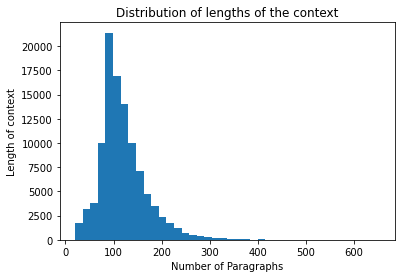

In [ ]:
import matplotlib.pyplot as plt
plt.hist(context_lens, bins=40)
plt.title("Distribution of lengths of the context")
plt.ylabel("Length of context")
plt.xlabel("Number of Paragraphs")
plt.show()

In [ ]:
print("Mimimum context length: ", np.min(context_lens))
print("Median context length: ", np.median(context_lens))
print("Mean context length: ", np.mean(context_lens))
print("Maximum context length: ", np.max(context_lens))
print("SD of context length: ", np.std(context_lens))

Mimimum context length:  20
Median context length:  109.0
Mean context length:  119.50346745959426
Maximum context length:  653
SD of context length:  49.31536011370435


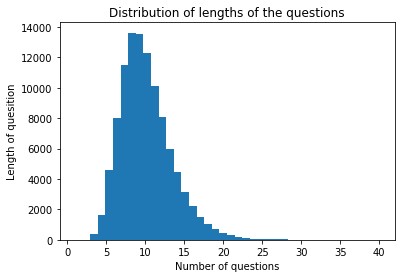

Mimimum question length:  1
Median question length:  9.0
Mean question length:  9.899515610762073
Maximum question length:  40
SD of question length:  3.420197922623825


In [ ]:
question_lens = []
for i in train["question"]:
  question = i.split()
  question_len = len(question)
  question_lens.append(question_len)
plt.hist(question_lens, bins=40)
plt.title("Distribution of lengths of the questions")
plt.ylabel("Length of quesition")
plt.xlabel("Number of questions")
plt.show()
print("Mimimum question length: ", np.min(question_lens))
print("Median question length: ", np.median(question_lens))
print("Mean question length: ", np.mean(question_lens))
print("Maximum question length: ", np.max(question_lens))
print("SD of question length: ", np.std(question_lens))

Next we can assess the percentage of answerable questions and look at examples of what makes a question unanswerable

In [ ]:
print("The number of passages is: ", len(train.groupby("data.title").count()))
imposib = train.groupby("is_impossible").count()["question"][1]
posib = train.groupby("is_impossible").count()["question"][0]
print("The number of answerable questions is: ", posib)
print("The number of unanswerable questions is: ", imposib)
print("The percent of answerable questions is: ", (posib / (posib + imposib)) * 100, "%")

The number of passages is:  442
The number of answerable questions is:  69504
The number of unanswerable questions is:  34751
The percent of answerable questions is:  66.6673061244065 %


Lets look deeper into the questions with answers

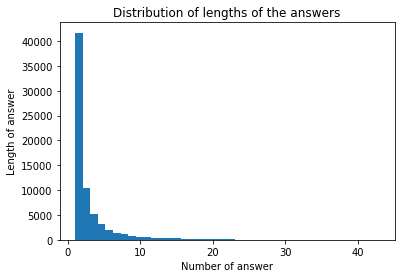

Mimimum answer length:  1
Median answer length:  2.0
Mean answer length:  3.1670695211786373
Maximum answer length:  43
SD of answer length:  3.398619665335489


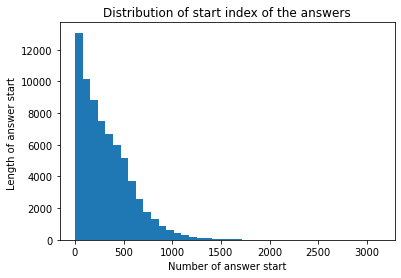

Mimimum answer start length:  0
Median answer start length:  262.0
Mean answer start length:  319.40761682780845
Maximum answer start length:  3126
SD of answer start length:  265.40157169194714


In [ ]:
#Answerable Question Answers
answer_lens = []
answer_start = []
for i in train["answers"]:
  if i != []: 
    answer = i[0]["text"].split()
    start = i[0]["answer_start"]
    answer_len = len(answer)
    answer_lens.append(answer_len)
    answer_start.append(start)
plt.hist(answer_lens, bins=40)
plt.title("Distribution of lengths of the answers")
plt.ylabel("Length of answer")
plt.xlabel("Number of answer")
plt.show()
print("Mimimum answer length: ", np.min(answer_lens))
print("Median answer length: ", np.median(answer_lens))
print("Mean answer length: ", np.mean(answer_lens))
print("Maximum answer length: ", np.max(answer_lens))
print("SD of answer length: ", np.std(answer_lens))

plt.hist(answer_start, bins=40)
plt.title("Distribution of start index of the answers")
plt.ylabel("Length of answer start ")
plt.xlabel("Number of answer start")
plt.show()
print("Mimimum answer start length: ", np.min(answer_start))
print("Median answer start length: ", np.median(answer_start))
print("Mean answer start length: ", np.mean(answer_start))
print("Maximum answer start length: ", np.max(answer_start))
print("SD of answer start length: ", np.std(answer_start))

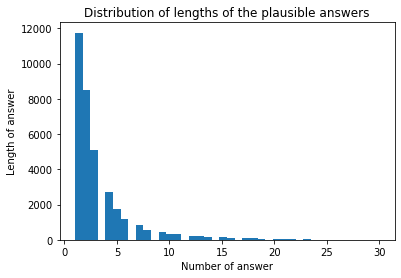

Mimimum answer length:  1
Median answer length:  2.0
Mean answer length:  3.2093752697764093
Maximum answer length:  30
SD of answer length:  3.2500050824711595


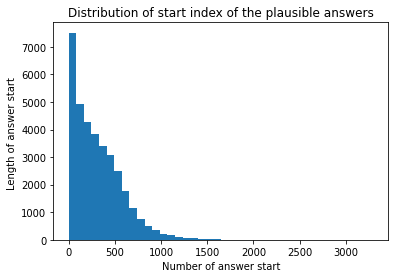

Mimimum answer start length:  0
Median answer start length:  260.0
Mean answer start length:  314.653304940865
Maximum answer start length:  3292
SD of answer start length:  266.09362603923483


In [ ]:
import pandas as pd
#Unanswerable Question Plausible Answers
answer_lens = []
answer_start = []
for i in train["plausible_answers"]:
  if pd.notna(i): 
    answer = i[0]["text"].split()
    start = i[0]["answer_start"]
    answer_len = len(answer)
    answer_lens.append(answer_len)
    answer_start.append(start)
plt.hist(answer_lens, bins=40)
plt.title("Distribution of lengths of the plausible answers")
plt.ylabel("Length of answer")
plt.xlabel("Number of answer")
plt.show()
print("Mimimum answer length: ", np.min(answer_lens))
print("Median answer length: ", np.median(answer_lens))
print("Mean answer length: ", np.mean(answer_lens))
print("Maximum answer length: ", np.max(answer_lens))
print("SD of answer length: ", np.std(answer_lens))

plt.hist(answer_start, bins=40)
plt.title("Distribution of start index of the plausible answers")
plt.ylabel("Length of answer start ")
plt.xlabel("Number of answer start")
plt.show()
print("Mimimum answer start length: ", np.min(answer_start))
print("Median answer start length: ", np.median(answer_start))
print("Mean answer start length: ", np.mean(answer_start))
print("Maximum answer start length: ", np.max(answer_start))
print("SD of answer start length: ", np.std(answer_start))

In [ ]:
pd.set_option('display.max_colwidth', -1)
train[train.is_impossible == True].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,question,id,answers,is_impossible,plausible_answers,version,data.title,data.paragraphs.context
120255,What city is southwest of Almaden?,5ad4d0325b96ef001a10a173,[],True,"[{'text': 'Madrid', 'answer_start': 430}]",v2.0,Red,"The Romans liked bright colors, and many Roman villas were decorated with vivid red murals. The pigment used for many of the murals was called vermilion, and it came from the mineral cinnabar, a common ore of mercury. It was one of the finest reds of ancient times – the paintings have retained their brightness for more than twenty centuries. The source of cinnabar for the Romans was a group of mines near Almadén, southwest of Madrid, in Spain. Working in the mines was extremely dangerous, since mercury is highly toxic; the miners were slaves or prisoners, and being sent to the cinnabar mines was a virtual death sentence."
40136,Who comprised the original Microsoft team besides Raskin?,5ad501c15b96ef001a10a939,[],True,"[{'text': 'Howard, Joanna Hoffman, Burrell Smith, and Bud Tribble', 'answer_start': 204}]",v2.0,Macintosh,"Raskin was authorized to start hiring for the project in September 1979, and he immediately asked his long-time colleague, Brian Howard, to join him. His initial team would eventually consist of himself, Howard, Joanna Hoffman, Burrell Smith, and Bud Tribble. The rest of the original Mac team would include Bill Atkinson, Bob Belleville, Steve Capps, George Crow, Donn Denman, Chris Espinosa, Andy Hertzfeld, Bruce Horn, Susan Kare, Larry Kenyon, and Caroline Rose with Steve Jobs leading the project."
115260,What is the purpose of bacterial strains?,5a65d2b2c2b11c001a425d6c,[],True,"[{'text': 'survive high doses of antibiotics', 'answer_start': 299}]",v2.0,Antibiotics,"The emergence of resistance of bacteria to antibiotics is a common phenomenon. Emergence of resistance often reflects evolutionary processes that take place during antibiotic therapy. The antibiotic treatment may select for bacterial strains with physiologically or genetically enhanced capacity to survive high doses of antibiotics. Under certain conditions, it may result in preferential growth of resistant bacteria, while growth of susceptible bacteria is inhibited by the drug. For example, antibacterial selection for strains having previously acquired antibacterial-resistance genes was demonstrated in 1943 by the Luria–Delbrück experiment. Antibiotics such as penicillin and erythromycin, which used to have a high efficacy against many bacterial species and strains, have become less effective, due to the increased resistance of many bacterial strains."
94026,Where did Palermo expand to in the early 2000's?,5a3ea39b5a76c5001a3a83f4,[],True,"[{'text': 'outside the old city walls', 'answer_start': 596}]",v2.0,Palermo,"The majority of Sicilians preferred independence to the Savoia kingdom; in 1866, Palermo became the seat of a week-long popular rebellion, which was finally crushed after Martial law was declared. The Italian government blamed anarchists and the Church, specifically the Archbishop of Palermo, for the rebellion and began enacting anti-Sicilian and anti-clerical policies. A new cultural, economic and industrial growth was spurred by several families, like the Florio, the Ducrot, the Rutelli, the Sandron, the Whitaker, the Utveggio, and others. In the early twentieth century Palermo expanded outside the old city walls, mostly to the north along the new boulevards Via Roma, Via Dante, Via Notarbartolo, and Viale della Libertà. These roads would soon boast a huge number of villas in the Art Nouveau style. Many of these were designed by the famous architect Ernesto Basile. The Grand Hotel Villa Igiea, designed by Ernesto Basile for the Florio family, is a good example of Palermitan Art Nouveau. The huge Teatro Massimo was designed in the same period by Giovan Battista Filippo Basile, and built by the Rutelli & Machì building firm of the industrial and old Rutelli Italian family in Palermo, and was opened in 1897."
116233

### Q1: Initial data observations
What are your initial observations after you explore the dataset?

**Answer:**

Although there are over 100,000 questions in the dataset, these questions stem from only 442 different passages. 

When further analyzing the passages, I found that most passages are about 109 words long, with the minimum being 20 words and the maximum being 653. The standard deviation was about 50, meaning most paragraphs were between 60 and 160 words long. 

I then did the same thing for the questions, finding most questions to be between 6-12 words with a median of 9 words. The minimum length was 1, which I guess is the question "why" or a syntax error. The max was 40. 

One of the most notable observations is that 66.67% of the questions are answerable. This means that almost exactly 2 out of every 3 questions will be answerable, while 1/3 will not be.

I then analyzed the make up of the answers and plausible answers to see if there was a significant difference between these. I found that there was not, since both plausible and real answers were about the same length and found at the same average index in a paragraph, about 260. 

Next, I wanted to dive deeper into what types of questions are unanswerable. 
1) Impossible condition: One example is "What city is southwest of Almaden?". The paragraph describes Almaden as being southwest of Madrid, but never mentioned anything about cities that are southwest of Almanden. 

2) Entity swap: "Who comprised the original Microsoft team besides Raskin?" 
While it seems like there's a very plausible answer in the text for this question, the paragraph is refering to the original *Macintosh* team, not the Microsoft team. 

3) Other Neutral: "What roles have interpreters occasionally lied about in history?". The paragraph states that interpreters play a crucial role in history, but never actually refer to anything an interpreter would lie about.

After looking at some examples like the ones described above, I was impressed by the plausibility of the answers of sometimes "unanswerable" questions. Many could easily be misunderstood by a human, and even more an algorithm. 


The two metrics we will be using are **exact match** and **F1**. The exact match metric measures the percentage of predictions that match any one of the ground truth answers **exactly**. The F1 score is a looser metric, which measures the average overlap between the prediction and ground truth answer.

The F1 metric on answers is defined as:

$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

where $Precision$ is:
$$Precision = \frac{TP}{TP + FP} = \frac{\text{# of matching tokens}}{\text{# of predicted tokens}}$$

and $Recall$ is:
$$Recall = \frac{TP}{TP + FN} = \frac{\text{# of matching tokens}}{\text{# of gold tokens}}$$

and $TP$ refers to the number of true positives; $FP$ is the number of false positives; and $FN$ is the number of false negatives. (See Jurafsky & Martin Ch. 4.7).

These are then also averaged with the "has answer" prediction where we replace the individual question-answer pair score with a 1 if it correctly predicts that the question is not answerable, and keep the original score otherwise.

### Q1.1: The metrics

How much time does it take to compute these metrics? When will these metrics correlate well/poorly with human judgement of answer quality? Please implement the metric yourself.


In [ ]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

In [ ]:
# Another batch of helper functions, feel free to modify as needed
def apply_no_ans_threshold(scores, na_probs, qid_to_has_ans):
    """apply_no_ans_threshold applies the no-answer threshold (or mapping) to
    the no-ans probabilities/predictions.

    :param scores: A mapping of qid to the f1 or em score
    :type scores: dict[qid: str, score: float]
    :param na_probs: A mapping of qid to the no answer prediction/probability
    :type na_probs: dict[qid: str, score: float]
    :qid_to_has_ans: A mapping of qid to answerability
    :type qid_to_has_ans: dict[qid: str, answerability: bool]
    :returns: A mapping of qid to new scores accounting for answerability
    :rtype: dict[qid: str, score: float]
    """
    new_scores = {}
    for qid in scores:
      if na_probs[qid] == 1:
        if qid_to_has_ans[qid]:
          new_scores[qid] = 0
        else:
          new_scores[qid] = 1
      else:
        if qid_to_has_ans[qid]:
          new_scores[qid] = scores[qid]
        else:
          new_scores[qid] = 0
    return new_scores

def make_eval_dict(exact_scores, f1_scores, qid_list=None):
    """make_eval_dict makes a dictionary from the individual scores of qa pairs.
    
    :param exact_scores: Mapping of qid to the em score
    :type exact_scores: dict[qid: str, score: float]
    :param f1_scores: Mapping of qid to f1 score
    :type f1_scores: dict[qid: str, score: float]
    :param qid_list: List of qid's to aggregate, used to separate HasAns and
        NoAns scores for better analysis of models
    :type qid_list: List[qid: str]
    :returns: mapping of relevant evaluation metrics to their scores
    :rtype: OrderedDict[value: str, score: float]
    """
    f1s = []
    ems = []
    total = 0
    if qid_list == None:
      for qid in exact_scores:
        ems.append(exact_scores[qid])
        f1s.append(f1_scores[qid])
        total += 1
    else:
      for qid in qid_list:
        ems.append(exact_scores[qid])
        f1s.append(f1_scores[qid])
        total += 1
    avg_f1 = np.sum(f1s)/total
    avg_ems = np.sum(ems)/total
    return collections.OrderedDict([("exact", avg_ems),("f1", avg_f1),("total", total),])

def merge_eval(main_eval, new_eval, prefix):
    """merge_eval is a helper to merge two outputs of make_eval_dict.

    This is useful for cases when we want to have the aggregate scores, but also
    want to look at the scores for HasAns and for NoAns. Using make_eval_dict,
    we can take only those that have an answer, compute and merge with the
    original eval_dict.

    :param main_eval: The main evaluation dictionary that you report from
    :type main_eval: dict[value: str, score: float]
    :param new_eval: The new evaluation dictionary that you want to merge in
    :type new_eval: dict[value: str, score: float]
    :param prefix: The prefix you want attached to the new_eval scores.
        For example, HasAns as a prefix can be used to get HasAns_f1.
    :type prefix: str
    :returns: combination of main_eval and new_eval with prefix on new_eval keys
    :rtype: OrderedDict[value: str, score: float]
    """
    for k in new_eval:
        main_eval['%s_%s' % (prefix, k)] = new_eval[k]

In [ ]:
# metric implementation here
def compute_exact(a_gold, a_pred):
  token_pred = a_pred
  token_gold = a_gold
  for tok in token_pred:
    if tok not in token_gold:
      return 0
  return 1

def compute_f1(a_gold, a_pred):
  token_pred = a_pred
  precision = 0; recall = 0
  token_gold = a_gold
  num_match = 0
  num_pred = len(a_pred)
  num_gold = len(a_gold)
  for tok in token_pred:
    if tok in token_gold:
      num_match +=1
  if num_pred > 0: 
    precision = num_match / num_pred
  recall = num_match / num_gold
  if precision + recall == 0:
    return 0
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

### How much time will it take to complete these metrics

1. F Score: For one question, it will take O(n) time to compute, where n is the length of the predicted answer tokens

2. Exact Score: For one question, it will take O(n) time to compute, where n is the length of the predicted answer tokens

To iterate over a list of questions, where l is the number of questions to predict, the metric will take O(n*l) time. To compute both of these metrics for an example, it will take O(2n * l) time, which is essentially filtered down to O(n * l) time. 

### When will these metrics correlate well/poorly with human judgement of answer quality? 

These metrics will correlate well with human judgement when the the QA machine predicts the exact words that align with the actual answers. These metrics can align very poorly if the QA machine chooses an answer that is similar, but not quite the same verbage, since these metrics can only measure how much of the exact words are predicted.

# Model 1: Pick your own model

---

In this part of the project you will implement a model to perform well on the SQuAD dataset. The features that you use are entirely up to you. As always, a good strategy is to work through lots of examples from the training data to determine what types of features would be most useful. You are **NOT** allowed to use (i) deep contextualized pre-trained language models (e.g. ELMo, GPT, BERT) since they will be covered in Part B, or (ii) any existing code written for the SQUAD task. Otherwise, feel free to re-use any code you have written for previous projects in the class as well as **general** ML/NLP tools (e.g., PyTorch, spaCy). Please use the code block below to code, prototype, and test your language model:

Code of Academic Integrity:  We encourage collaboration regarding ideas, etc. However, please **do not copy code from online or share code with other students**. We will be running programs to detect plagiarism.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md', parser=False)
# tagger=False, entity=False

In [ ]:
train.head()

,question,id,answers,is_impossible,plausible_answers,version,data.title,data.paragraphs.context
100422,Which 1962 US Supreme Court ruling forced stat...,572ca3fcf182dd1900d7c812,"[{'text': 'Baker v. Carr', 'answer_start': 4}]",False,NaN,v2.0,Tennessee,The Baker v. Carr (1962) decision of the US Su...
83756,What was the religion of the western half of B...,5728c1bc4b864d1900164d74,"[{'text': 'Muslim', 'answer_start': 132}]",False,NaN,v2.0,History_of_India,"In 1905, Lord Curzon split the large province ..."
120255,What city is southwest of Almaden?,5ad4d0325b96ef001a10a173,[],True,"[{'text': 'Madrid', 'answer_start': 430}]",v2.0,Red,"The Romans liked bright colors, and many Roman..."
62471,What methods are used to remove non-audible co...,57267b155951b619008f7419,"[{'text': 'psychoacoustics', 'answer_start': 39}]",False,NaN,v2.0,Data_compression,"In lossy audio compression, methods of psychoa..."
36625,Where did the American army fight the Spanish ...,570b431eec8fbc190045b92e,"[{'text': 'Cuba', 'answer_start': 360}]",False,NaN,v2.0,Military_history_of_the_United_States,The Spanish–American War was a short decisive ...


In [ ]:
def subfinder(mylist, pattern):
  matches = []
  if pattern == []: 
    return []
  for i in range(len(mylist)):
    if mylist[i] == pattern[0] and i+len(pattern) < len(mylist):
      if mylist[i:i+len(pattern)] == pattern:
        matches.append(i)
  if matches == []:
     return []
  match_first = matches[0]
  return [match_first, match_first + len(pattern) - 1]

def tokens_of_answers(context, ans_st, ans_end):
  s_tokens = get_tokens(context)
  if np.isnan(ans_st): 
    return (0, 0)
  ans_words = context[ans_st:ans_end]
  ans_tokens = get_tokens(ans_words)

  tok_list = subfinder(s_tokens, ans_tokens)
  # print(tok_list)
  if tok_list == []:
    return (0, 0)
  return (tok_list[0], tok_list[-1])
  

Data Preprocessing

In [ ]:
def training_process(data):
  new_data = []
  for i in range(len(data)):
    examp = data.iloc[i,:]
    context = examp["data.paragraphs.context"].replace("''", '" ').replace("``", '" ')
    question = examp["question"].replace("''", '" ').replace("``", '" ')
    ans_start = np.nan; ans_end = np.nan
    for a in examp["answers"]:
      answer = examp["answers"][0]["text"]
      ans_start = examp["answers"][0]['answer_start']
      ans_end = ans_start + len(answer)
    if np.isnan(ans_start):
      has_ans = 0
      answer = ""
    else:
      has_ans = 1
    token_st, token_end = tokens_of_answers(context, ans_start, ans_end)
    id = examp["id"]
    new_data.append((id, context, question, answer, ans_start, ans_end, has_ans, token_st, token_end))
  new_data = pd.DataFrame(new_data, columns=['id', 'context', 'question', 'answer','ans_start', 'ans_end', 'has_ans', 'token_st', 'token_end'])
  return new_data

def val_process(data):
  new_data = []
  for i in range(len(data)):
    examp = data.iloc[i,:]
    context = examp["data.paragraphs.context"].replace("''", '" ').replace("``", '" ')
    question = examp["question"].replace("''", '" ').replace("``", '" ')
    answers = examp["answers"]
    answers = [ans["text"] for ans in answers]
    id = examp["id"]
    new_data.append((id, context, question, answers))
  new_data = pd.DataFrame(new_data, columns=['id', 'context', 'question', 'answers'])
  return new_data

In [ ]:
import torch
def tokenize_words(s):
  doc = nlp(s)
  return [tok for tok in doc]

def tokenize_word(s):
  doc = nlp(s)
  return doc
  
def make_vocab(data):
    vocab = {}
    tokens = {}
    id = 0
    for i in range(len(data)):
      document = data.iloc[i,:]["context"].replace("''", '" ').replace("``", '" ')
      document2 = data.iloc[i,:]["question"].replace("''", '" ').replace("``", '" ')
      document_tokens = get_tokens(document)
      doc2_tokens = get_tokens(document2)
      for word in document_tokens:
        if word not in vocab:
          id += 1
          vocab[word] = id
      for word in doc2_tokens:
        if word not in vocab:
          id += 1
          vocab[word] = id
    vocab["unk"] = 0
    return vocab

In [ ]:
training = training_process(train)
validation = training_process(val)
validation.head(15)

,id,context,question,answer,ans_start,ans_end,has_ans,token_st,token_end
0,57269f3b708984140094cc01,Found in applications as diverse as industrial...,What does AC stand for?,alternating current,262.0,281.0,1,40,41
1,572ea25103f989190075686d,The dipole component of the magnetic field at ...,What is Neptune's dipole magnetic moment?,2.2 × 1017 T·m3,159.0,174.0,1,23,26
2,5ad25596d7d075001a428d40,Such a theory would be true with higher probab...,What is less important than detecting the fals...,,NaN,NaN,0,0,0
3,5acf58ea77cf76001a684be0,"After the Romans left, Britain was invaded by ...",Who led the forces against the rebels in the M...,,NaN,NaN,0,0,0
4,5ad39902604f3c001a3fe812,"The FBI Laboratory, established with the forma...",Where was the CIA lab located?,,NaN,NaN,0,0,0
5,56f7488caef2371900625ab0,^9 Sub-groups of Croats include Bunjevci (in B...,Where are Burgenland Croats located?,Austria,132.0,139.0,1,19,19
6,572a31636aef051400155357,"The Christian population of the empire, owing ...",Jews and Christians were offered protection in...,consuls and citizenship,1009.0,1032.0,1,153,155
7,56f733273d8e2e1400e3744e,"The language of treaties, like that of any law...",What states that treaties are to be interprete...,The Vienna Convention,214.0,235.0,1,34,35
8,57302bc5b2c2fd14005689d5,"At the time of the Roman Empire, about two tho...",What was the name of the native people that li...,Britons,528.0,535.0,1,0,0
9,57312d2a05b4da19006bce4b,Red was the color of the banner of the Byzanti...,In what year did cardinals in the Roman Cathol...,1295,235.0,239.0,1,36,36


In [ ]:
vocab = make_vocab(training)

In [ ]:
#example for embedding 
import torch.nn as nn
def make_weights(vocab):
  n_vocab = len(vocab)
  weights = np.zeros((n_vocab, 300))
  pos_map = {}
  ner_map = {}
  for i, word in enumerate(vocab):
    try:
      cur_word = nlp(word)
      weights[i] = cur_word.vector
      pos_map[word] = cur_word[0].pos
      ner_map[word] = cur_word[0].ent_iob
    except KeyError:
      weights[i] = np.random.normal(scale=0.6, size=(300, ))
  return weights, pos_map, ner_map

def doc_to_inx(vocab, doc):
  as_inx = np.zeros((len(doc),))
  i = 0
  for word in get_tokens(doc):
    ind = vocab[word]
    as_inx[i] = ind
    i += 1
  return as_inx

def doc_to_id(mapping,doc):
  return torch.tensor([mapping[word] if word in mapping else 0 for word in doc])

In [ ]:
glove_weights, pos_map, ner_map = make_weights(vocab)

In [ ]:
def convert_back(c, vocab, keys, vals):
  tokens = []
  for ind in c:
    pos = vals.index(ind)
    word = keys[pos]
    tokens.append(word)
  return tokens

In [ ]:
def convert_to_inds(data):
  train_data = []
  for i in range(len(data)):
    document = data.iloc[i,:]["context"]
    document2 = data.iloc[i,:]["question"]
    context_inds = doc_to_id(vocab, get_tokens(document))
    context_pos = doc_to_id(pos_map, get_tokens(document))
    context_ner = doc_to_id(ner_map, get_tokens(document))
    question_inds = doc_to_id(vocab, get_tokens(document2))
    context = torch.stack((context_inds.float(), context_pos, context_ner)) 
    ans_st = data.iloc[i,:]["token_st"]
    ans_end = data.iloc[i,:]["token_end"]
    has_ans = data.iloc[i,:]["has_ans"]
    id = data.iloc[i,:]["id"]
    train_data.append((context, question_inds.float(),ans_st, ans_end, has_ans, id))
  return train_data

def make_info(pos_map, ner_map, h_dim, vocab):
  info = {"pos_map": pos_map, "ner_map": ner_map, "h_dim":h_dim}
  pos_unique = set( val for val in pos_map.values())
  ner_unique = set( val for val in ner_map.values())
  info["pos_size"] = len(pos_unique)
  info["ner_size"] = len(ner_unique)
  info["vocab"] = vocab
  return info

In [ ]:
train_data= convert_to_inds(training)
val_data= convert_to_inds(validation)

In [ ]:

# Then, we create a list of indices for all samples in the dataset
train_indices = [i for i in range(len(training))]
val_indices = [i for i in range(len(validation[0:1000]))]

# Now we define samplers and loaders for train and val
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(train_data, batch_size=1, sampler=train_sampler)
    
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(val_data, batch_size=1, sampler=val_sampler)

# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
info = make_info(pos_map, ner_map, 300, vocab)

In [ ]:
glove_weights_tensor = torch.from_numpy(glove_weights)
glove_weights_tensor.size()

torch.Size([104679, 300])

## Making Model Layers

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
import torch.nn.functional as F
# initial rnn to transform the context and the question into hidden dimensions
class RNN(nn.Module):
  def __init__(self,input_dim, h_dim, weights, n_layers=1): 
    # Add relevant parameters
    super(RNN, self).__init__()
    # Fill in relevant parameters
    self.hidden_dim = h_dim
    self.input_dim = input_dim
    self.n_layers = n_layers
    self.rnn = nn.LSTM(input_dim, h_dim, batch_first=True,bidirectional=True)
    self.loss = nn.NLLLoss()

  def compute_loss(self, predicted_vector, gold_label):
    return self.loss(predicted_vector, gold_label)	

  def forward(self, inputs):
    inputs = inputs.transpose(0,1)
    output, hidden = self.rnn(inputs)
    output = output.transpose(0,1)
    return output

  def load_model(self, save_path):
    self.load_state_dict(torch.load(save_path))
	
  def save_model(self, save_path):
    torch.save(self.state_dict(), save_path)

In [ ]:
# class to get the sequencial attention model between the context and the question 
class Attention(nn.Module):
    def __init__(self, input_size):
        super(Attention, self).__init__()
        self.linear = nn.Linear(input_size, input_size)

    def forward(self, c, q):
        c = c.unsqueeze(0).float()
        q = q.float()
        cp = self.linear(c.view(-1, c.size(2))).view(c.size())
        cp = F.relu(cp)
        qp = self.linear(q.view(-1, q.size(2))).view(q.size())
        qp = F.relu(qp)
        cq = cp.bmm(qp.transpose(2, 1))
        a = F.softmax(cq.view(-1, q.size(1)), dim=-1)
        alpha = a.view(-1, c.size(1), q.size(1))
        return alpha.bmm(q).squeeze(0)

In [ ]:
# class to get the self-attention matrix from the question 
class QuestionAttention(nn.Module):
    def __init__(self, input_size):
        super(QuestionAttention, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, q):
        q_flat = q.view(-1, q.size(-1))
        vector = self.linear(q_flat).view(q.size(0), q.size(1))
        return F.softmax(vector, dim=-1)

#returns weights of the question attention layer
def weights(x, weights):
  return weights.unsqueeze(1).bmm(x).squeeze(1)

In [ ]:
# class to get the final prediction classifations of the start index
class BilinearAttention(nn.Module):
    def __init__(self, content_size, question_size):
        super(BilinearAttention, self).__init__()
        self.linear = nn.Linear(question_size, content_size)
  
    def forward(self, p, q):
        Wq = self.linear(q)
        pWq = p.bmm(Wq.unsqueeze(2)).squeeze(2)
        pWq = p.bmm(Wq.unsqueeze(2)).squeeze(2)
        alpha = F.log_softmax(pWq, dim=-1)
        return alpha

Making the Model Network: Stringing the Layers Together

In [ ]:
class RnnNetwork(nn.Module):
  def __init__(self, weights, info):
    super(RnnNetwork, self).__init__()
    self.weights = weights
    num_embed, embed_dim = weights.size()
    self.embedding = nn.Embedding(num_embed, embed_dim)
    self.embedding.weight.data = weights
    self.pos_embedding = nn.Embedding(120, 1)
    self.ner_embedding = nn.Embedding(10, 1)
    self.context_input_size = 2 * embed_dim + 1 + 1
    self.loss = nn.NLLLoss()

    #RNN for the context
    self.context_rnn = RNN(self.context_input_size, info["h_dim"], weights)
    #RNN for the question
    self.question_rnn = RNN(embed_dim, info["h_dim"], weights)
    self.rnn_hidden_size = info["h_dim"] * 2
    #self attention for the question
    self.self_attention = QuestionAttention(self.rnn_hidden_size)
    #sequence attention layer
    self.sequence_attention = Attention(embed_dim)
    #attention to get start token layer
    self.start_attn = BilinearAttention(self.rnn_hidden_size, self.rnn_hidden_size)
    #attention to get end token layer
    self.end_attn = BilinearAttention(self.rnn_hidden_size, self.rnn_hidden_size)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def compute_loss(self, predicted_vector, gold_label):
    return self.loss(predicted_vector, gold_label)
  
  def forward(self, c, c_pos, c_ner, q):
    context_embed = self.embedding(c)
    question_embed = self.embedding(q).float()
    pos_embed = self.pos_embedding(c_pos.int().long())
    ner_embed = self.ner_embedding(c_ner.int().long())
    attn = self.sequence_attention(context_embed, question_embed)
    cinputs = [context_embed, pos_embed, ner_embed, attn]
    cinputs = torch.cat(cinputs, 1).float()
    hidden_context = self.context_rnn(cinputs.unsqueeze(0))
    hidden_question = self.question_rnn(question_embed)
    q_self_attn = self.self_attention(hidden_question)
    hidden_question2 = weights(hidden_question, weights = q_self_attn)
    start_scores = self.start_attn(hidden_context, hidden_question2)
    end_scores = self.end_attn(hidden_context, hidden_question2)
    to_out = nn.Linear(start_scores.size()[1], 2).to(get_device())
    ans_output = to_out(start_scores)
    ans_out = self.softmax(ans_output)
    return start_scores, end_scores, ans_out


Now that we have the model built, lets train the model

In [ ]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
# get_device = lambda : "cpu"
print(torch.cuda.is_available())

def train_epoch(model, train_loader, optimizer, info):
  model.train()
  torch.no_grad()
  i = 0 
  total = 0
  for (input_context, input_question, expected_start,expected_end, answerable, id) in tqdm(train_loader, leave=False, desc="Training Batches"):
    context = input_context.to(get_device()).long()
    question = input_question.to(get_device()).long()
    start_output, end_output, ans_output = model(context[0][0], context[0][1], context[0][2], question)
    target_start = expected_start.to(get_device())
    target_end = expected_end.to(get_device())
    target_answer = answerable.to(get_device())
    start_output = start_output[0].unsqueeze(0)
    end_output = end_output[0].unsqueeze(0)
    ans_output = ans_output[0].unsqueeze(0)
    _, predicted_ans = torch.max(ans_output, 1)
    predicted_ans = predicted_ans.cpu().numpy()[0]
    total += start_output.size()[0]
    loss = model.compute_loss(ans_output, target_answer)
    if predicted_ans == 1:
      loss += model.compute_loss(start_output, target_start) + model.compute_loss(end_output, target_end)
    optimizer.zero_grad()
    loss.backward()
    # torch.norm(model.rnn.weight_ih_l0.grad)
    # torch.norm(model.rnn.weight_hh_l0.grad)
    # torch.norm(model.to_out.weight.grad)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    i += 1
  return

def evaluation(model, val_loader, optimizer, info):
  model.eval()
  torch.no_grad()
  loss = 0
  vocab = info["vocab"]
  key_list = list(vocab.keys())
  val_list = list(vocab.values())
  f1_scores = {}
  exact_scores = {}
  na_probs = {}
  qid_has_ans = {}
  pred_ints = []
  for (input_context, input_question, expected_start,expected_end, answerable, id) in tqdm(val_loader, leave=False, desc="Validation Batches"):
    context = input_context.to(get_device()).long()
    question = input_question.to(get_device()).long()
    start_output, end_output, ans_output = model(context[0][0], context[0][1], context[0][2], question)
    target_start = expected_start.to(get_device())
    target_end = expected_end.to(get_device())
    target_answer = answerable.to(get_device())
    start_output = start_output[0].unsqueeze(0)
    end_output = end_output[0].unsqueeze(0)
    ans_output = ans_output[0].unsqueeze(0)
    _, predicted_ans = torch.max(ans_output, 1)

    scores = torch.outer(start_output[0].to("cpu"), end_output[0].to("cpu"))
    scores.triu_().tril_(12 - 1)
    scores = scores.detach().numpy()
    pred_start_ind, pred_end_ind = np.unravel_index(np.argmax(scores), scores.shape)
    pred_ints.append((pred_start_ind, pred_end_ind))

    pred_answer = input_context[0][0][pred_start_ind:pred_end_ind + 1]
    act_answer = input_context[0][0][target_start.to("cpu"):target_end.to("cpu")+1]

    pred_answer_tokens = convert_back(pred_answer, vocab, key_list, val_list)
    act_answer_tokens = convert_back(act_answer, vocab, key_list, val_list)

    f1 = compute_f1(act_answer_tokens, pred_answer_tokens)
    exct = compute_exact(act_answer_tokens, pred_answer_tokens)
    f1_scores[id] = f1
    exact_scores[id] = exct 
    na_probs[id] = predicted_ans
    qid_has_ans[id] = target_answer
    loss += model.compute_loss(ans_output, target_answer)
    loss += loss.detach().item()

  loss /= len(val_loader)
  # Print validation metrics
  print("loss: ", loss)
  f1_answerability = apply_no_ans_threshold(f1_scores, na_probs, qid_has_ans)
  exact_answerability = apply_no_ans_threshold(exact_scores, na_probs, qid_has_ans)
  eval_dict = make_eval_dict(exact_scores, f1_scores)
  return f1_answerability, exact_answerability, eval_dict, qid_has_ans 


def train_and_evaluate(number_of_epochs, model, train_loader, val_loader, info):
  # , input_seq, gold_labels
  optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
  for epoch in trange(number_of_epochs, desc="Epochs"):
    train_epoch(model, train_loader, optimizer, info)
    # f1_answerability, exact_answerability, eval_dict, qid_has_ans = evaluation(model, val_loader, optimizer,info)
  return f1_answerability, exact_answerability, eval_dict, qid_has_ans

True




### Q2 : Explain your  implementation

Q2.1: Explain here your implementation (e.g. **which algorithms/data structures** you used). Make clear which parts were implemented from scratch vs. obtained via an existing package. 

**Answer:** For my implementation, I decided to follow the DRQA paper as a general inspriation for my approach. I embedded the context and question matrices for a question and made predictions based on the Bilinear attention, which predicts the probability of the context word being the start or end token based on the question. My algorithm actually predicts 3 seperate models.
1. Probability that a token was the starting answer word, piWsq
2. Probability that a token was the ending answer word, piWeq
3. Probability that the question was answerable

After training my model, I evaluated it to be able to predict the actual token sequence. To get the predicted answer, I multiplied P(start) X P(end), and choose the maximum probability of a token i to i + 12. This means my answers were limited to a maximum length of 12 words, which I found from my initial analysis is about 3 standard deviations above the typical answer length, so I knew that would account for most answers.


Q2.2: Explain and motivate any design choices providing the intuition behind them (e.g. which methods you used for your implementation, why?).

**Answer:** Context design: To best include the pos and ner features calculated for context, I decided to make embeddings for all three things in my RnnNetwork. This way, my model would keep track of all embedding vectors for me and I wouldn't have to do a ton of extra work or use a ton of memory to keep the vectors, especially for the glove embeddings. The last portion of the context feature is the aligned question embedding, which comes from the DrQA paper. I chose to add this for extra information on where the context and question are similar. While I didn't include an exact match feature, I believe that the similarity scores, which act as a sort of soft matching, give even more information since the scores will be very high when there is an exact match but also high when words are similar but not the same. 

My biggest design choice was training 3 different models during the training phase. I did this to keep track of the most important features: P(start), P(end), and answerability. The answerability played a large role. While loss was updated for answerability for every training example, the start and end tag only contributed to loss if the question was predicted to be answerable. This allowed for my model to not get 'led astray' by start and end tags of questions that didn't actually have a real answer for them. This means my model will have more accurate results for questions with actual answers. 

By multiplying the start token scores by the end token scores, I was able to get answers of different lengths. This was the easiest way to get a high probability sequence. Since answers could come up multiple times throughout the context, just trying to find an answer token within the context did not cut it. By using this design, I was able to find the best sequence of tokens,whether that be 1 word or the maximum I set, 12 words. 

Q2.3: What features did you use and why? Please motivate your choices.

**Answer:** I gave my model the following features:
1. Glove embeddings of size 300 per word for the questions and the context. Using glove embeddings gives the user a ton of super insightful information above the properties of a specific word and is probably in my opinion the most crucial factor to include.

2. Part of Speech - For each word in a paragraph, I included the part of speech tag, which can be very useful since the model is trying to extract shorter blurbs. If there are overall patterns about what word types are typically used in answers (i.e. it seemed like most include a noun phrase), the model will be able to pick up on these. 

3. NER tags - These tags include whether a feature is the beginning, inside, or outside of a named entity. This is useful since a lot of times, the answer will include a named entity 



## Validation Step



In [ ]:
torch.cuda.empty_cache()
model = RnnNetwork(glove_weights_tensor, info).to(get_device())
torch.autograd.set_detect_anomaly(True)
epochs = 1
f1_answerability, exact_answerability, eval_dict, qid_has_ans = train_and_evaluate(epochs, model, train_loader, val_loader, info)

KeyboardInterrupt: ignored

As you can see, I ran out of memory before being able to go through the full validation data set. To be able to still do some type of evaluation of my fully trained model, I ran this on a validation set of about 1000 points. 

In [ ]:
torch.cuda.empty_cache()
model = RnnNetwork(glove_weights_tensor, info).to(get_device())
torch.autograd.set_detect_anomaly(True)
epochs = 1
f1_answerability, exact_answerability, eval_dict, qid_has_ans = train_and_evaluate(epochs, model, train_loader, val_loader, info)

NameError: ignored

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
f1_answerability, exact_answerability, eval_dict, qid_has_ans = evaluation(model, val_loader, optimizer,info)

loss:  tensor(inf, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
val_answers = pd.DataFrame(columns=["id", "exact_score", "f1_score", "has_ans"])
i = 0
for key in exact_answerability.keys():
  val_answers.loc[i] = [key, exact_answerability[key], f1_answerability[key], qid_has_ans[key].item()]
  i = i + 1

In [ ]:
val_answers.head()

,id,exact_score,f1_score,has_ans
0,"(5ad14abb645df0001a2d15c4,)",0,0,0
1,"(572ffb1904bcaa1900d76fad,)",0,0,1
2,"(571d2dbf5efbb31900334ec9,)",0,0,1
3,"(56f8fa3c9b226e1400dd1214,)",0,0,1
4,"(5ad1766e645df0001a2d1d0e,)",1,1,0


In [ ]:
validation[validation["id"] == "5ad14abb645df0001a2d15c4"]

,id,context,question,answer,ans_start,ans_end,has_ans,token_st,token_end
11,5ad14abb645df0001a2d15c4,"The ""yo yo"" in the opinion polls continued int...",When was any Conservative lead in the polls su...,,NaN,NaN,0,0,0


In [ ]:
has_an_ans = val_answers[val_answers["has_ans"]==1]
no_ans = val_answers[val_answers["has_ans"]==0]

In [ ]:
print("Exact Score Percentage: ", sum(val_answers["exact_score"]) / 1000, "%")
print("F1 Score Percentage: ", sum(val_answers["f1_score"]) / 1000, "%")
print("Percent of Examples with some or all guessed correctly: ", len(val_answers[val_answers["f1_score"]!=0]) / 1000, "%")
print("Percent Without an Answer: ", len(no_ans) / 1000, "%")
print("Percent With an Answer: ", len(has_an_ans) / 1000, "%")

print("Exact Score Percentage for those with Answer: ", sum(has_an_ans["exact_score"]) / len(has_an_ans), "%")
print("F1 Score Percentage for those with Answer: ", sum(has_an_ans["f1_score"]) / len(has_an_ans), "%")
print("Percent of Examples with some or all guessed correctly for those with Answer: ", len(has_an_ans[has_an_ans["f1_score"]!=0]) / len(has_an_ans), "%")

print("Exact Score Percentage for those without an Answer: ", sum(no_ans["exact_score"]) / len(no_ans), "%")
print("F1 Score Percentage for those without an Answer: ", sum(no_ans["f1_score"]) / len(no_ans), "%")
print("Percent of Examples with some or all guessed correctly for those without an Answer: ", len(no_ans[no_ans["f1_score"]!=0]) / len(no_ans), "%")

Exact Score Percentage:  0.19 %
F1 Score Percentage:  0.18367126322516794 %
Percent of Examples with some or all guessed correctly:  0.197 %
Percent Without an Answer:  0.338 %
Percent With an Answer:  0.662 %
Exact Score Percentage for those with Answer:  0.028700906344410877 %
F1 Score Percentage for those with Answer:  0.01914088100478533 %
Percent of Examples with some or all guessed correctly for those with Answer:  0.03927492447129909 %
Exact Score Percentage for those without an Answer:  0.5059171597633136 %
F1 Score Percentage for those without an Answer:  0.5059171597633136 %
Percent of Examples with some or all guessed correctly for those without an Answer:  0.5059171597633136 %


In [ ]:
import os
ans_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "drqa_preds.csv")
ans_path
val_answers.to_csv(ans_path)
!cp drqa_preds.csv ans_path

cp: cannot stat 'drqa_preds.csv': No such file or directory


### Q3: Results Analysis

Q3.1: Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

> Row Labels | Has Answer | Does Not Have Answer | All
>:--- | --- | --- | ---
>Average F1 Score | 1.91%| 50.92% | 18.37%
>Portion with nonzero F1 Score | 3.93%| 50.59%| 19.7%
> Exact Score | 2.87%| 50.6% | 19%

Q3.2: When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?

**Answer:** The system did not work super well. It was better at handling unknown words - However it didn't work super well. The probability of the system correctly guessing answerability was around 50%, which is no better than random. The system only managed to get f1 scores of about 3.93% which is frankly horrible. It did better, around 19% on exact score, which can be due to the fact that anything that correctly guessed not having an answer would have an exact score of 0. I'm not sure how my model managed to do so badly seeing as I was following a method I believed would give me good results and that I spent lots of lots of time on. One reason my model may have done poorly is that I wasn't sure what to put in for the answer start and answer ends if the model didn't have an actual answer. I put in 0,0. I think this may have mislead a lot of the other answers. I'm not totally sure why, since in training I only had my model learn from the start and end scores if the model was predicted to have an answer. Since this feature also turned out so poorly, only guessing right about half of the time, maybe thats why it learned the answers so poorly as well. I wonder if there was something wrong about my linear layer to two categories (answer or no answer) that made the results of my model so inaccurate. If I had more time, I would improve my system by adding in more features, such as tf scores to find the most important words in the model. I would also most definitely add more specific NER type tages. Lastly, I would add exact match features so that a model could more specifically tell if there was a word that served as an answer to a question in training so that later on the model could have a better type of ideas as to which words were already known to be exact matches. 

Q3.3: What is the effect of the method used for handling unknown words? Note: Even if you choose to skip over unknown words, that is still a _method_ of handling out-of-vocabulary terms.

**Answer:** I choose to skip over handling unknown words. The effect of skiping over unknown words is that my model won't assign any weight to words it hasn't seen before which can be detrimental to a model since words it hasn't encountered can still be very important words to find the answer or answerability of a model. By handling unknown words, it gives more probability to them that those words could be the answer instead of 0. 



# Part B: Fine-tune a Pre-trained Language Model

---

In this part, the goal is to build a strong system by fine-tuning a pre-trained language model. You can use **any** public code, **any** pre-trained language models, and **any** hardware resources -- anything other than code specifically written for SQUAD. A reasonable baseline F1 score to aim for is around 0.7.



In [ ]:
def make_lists(data):
  # contexts = []
  # questions = []
  # answers = []
  d = []
  for i in range(len(data)):
    c = data.iloc[i,:]["context"]
    q = data.iloc[i,:]["question"]
    ans_st = data.iloc[i,:]["token_st"]
    ans_end = data.iloc[i,:]["token_end"]
    a = {'ans_start':ans_st, 'ans_end':ans_end}
    # contexts.append(c)
    # questions.append(q)
    # answers.append(a)
    d.append((c, q, a))
  return d

# t_contexts, t_questions, t_answers = make_lists(training)
# v_contexts, v_questions, v_answers = make_lists(validation)
t_data = make_lists(training)
v_data = make_lists(validation)

In [ ]:
t_data[0]

('The Baker v. Carr (1962) decision of the US Supreme Court established the principle of "one man, one vote", requiring state legislatures to redistrict to bring Congressional apportionment in line with decennial censuses. It also required both houses of state legislatures to be based on population for representation and not geographic districts such as counties. This case arose out of a lawsuit challenging the longstanding rural bias of apportionment of seats in the Tennessee legislature. After decades in which urban populations had been underrepresented in many state legislatures, this significant ruling led to an increased (and proportional) prominence in state politics by urban and, eventually, suburban, legislators and statewide officeholders in relation to their population within the state. The ruling also applied to numerous other states long controlled by rural minorities, such as Alabama, Vermont, and Montana.',
 'Which 1962 US Supreme Court ruling forced states to realign the

In [ ]:
def convert_char_to_token(e, answers):
  sp = []; ep = []
  for i in range(len(answers['ans_start'])):
    sp.append(e.char_to_token(i, answers['ans_start'][i]))
    ep.append(e.char_to_token(i, answers['ans_end'][i]))
    # if None, the answer passage has been truncated
    if sp[-1] is None:
      sp[-1] = tokenizer.model_max_length
    if ep[-1] is None:
      ep[-1] = tokenizer.model_max_length
  e.update({'start_positions': sp, 'end_positions': ep})

# convert_char_to_token(train_encods, t_answers)
# convert_char_to_token(val_encods, v_answers)

import torch

get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

class MyDataset(Dataset):
    def __init__(self, data):
        self.contexts = [X for X, _, _ in data]
        self.questions = [Y for _,Y, _ in data]
        self.answers = [Z for _, _, Z in data]
        # self.encods = tokenizer(self.contexts, self.questions, truncation=True, padding=True)
        # self.encodings = convert_char_to_token(self.encods, self.answers)

    def __getitem__(self, idx):
        # return {key: torch.tensor(val) for key, val in encods.items()}
        # return encods
        return self.contexts[idx], self.questions[idx], self.answers[idx]

    def __len__(self):
        return len(self.contexts)

training_data = MyDataset(t_data)
validation_data = MyDataset(v_data)

from transformers import DistilBertForQuestionAnswering, BertForQuestionAnswering
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
# model = BertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
next(model.parameters()).device


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

device(type='cpu')

In [ ]:
model_to_use = model.to(get_device())
next(model_to_use.parameters()).device

device(type='cuda', index=0)

In [ ]:
train_loader = DataLoader(training_data, batch_size=12, shuffle=True)
val_loader = DataLoader(validation_data, batch_size=1, shuffle=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from transformers import AdamW

def train_epoch2(train_loader, model, optimizer):
  model.train()
  torch.no_grad()
  for contexts, questions, answers in tqdm(train_loader, leave=False, desc="Training Batches"):
    optimizer.zero_grad()
    batch = tokenizer(contexts, questions, truncation=True, padding=True)
    convert_char_to_token(batch, answers)
    input_ids = torch.LongTensor(batch['input_ids']).to(get_device())
    attn_mask = torch.LongTensor(batch['attention_mask']).to(get_device())
    sp = torch.LongTensor(batch['start_positions']).to(get_device())
    ep = torch.LongTensor(batch['end_positions']).to(get_device())
    outputs = model(input_ids, attention_mask=attn_mask, start_positions=sp, end_positions=ep)
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits
    to_out = nn.Linear(start_scores.size()[1], 2).to(get_device())
    answerable = to_out(start_scores)
    _, predicted_ans = torch.max(answerable, 1)
    if predicted_ans[0] == 1:
      loss = outputs[0].to(get_device())
      loss.backward()
    optimizer.step()
  return model

def eval_epoch2(val_loader, model, optimizer):
  model.eval()
  torch.no_grad()
  ans = []
  for contexts, questions, answers in tqdm(val_loader, leave=False, desc="Validation Batches"):
    # optimizer.zero_grad()
    batch = tokenizer(contexts, questions, truncation=True, padding=True)
    convert_char_to_token(batch, answers)
    input_ids = torch.LongTensor(batch['input_ids']).to(get_device())
    attn_mask = torch.LongTensor(batch['attention_mask']).to(get_device())
    sp = torch.LongTensor(batch['start_positions']).to(get_device())
    ep = torch.LongTensor(batch['end_positions']).to(get_device())
    output = model(input_ids, attention_mask=attn_mask, start_positions=sp, end_positions=ep)
    start_scores = output.start_logits
    end_scores = output.end_logits
    to_out = nn.Linear(start_scores.size()[1], 2).to(get_device())
    answerable = to_out(start_scores)
    _, predicted_ans = torch.max(answerable, 1)

    ans_start = torch.argmax(start_scores.cpu())
    ans_end = torch.argmax(end_scores.cpu())
    ans.append((ans_start, ans_end, predicted_ans))
  return ans
    


In [ ]:
def train_and_eval(number_of_epochs, model, t_loader, v_loader):
  optim = AdamW(model.parameters(), lr=5e-3)
  for epoch in trange(number_of_epochs, desc="Epochs"):
    new_model = train_epoch2(t_loader, model_to_use, optim)
    ans = eval_epoch2(v_loader, model_to_use, optim)
  return new_model, ans

In [ ]:
import torch.nn as nn
trained_model = train_and_eval(1, model_to_use, train_loader, val_loader)

In [ ]:
import torch.nn as nn
optim = AdamW(model.parameters(), lr=5e-5)
ans = eval_epoch2(val_loader, trained_model, optim)

In [ ]:
df = pd.DataFrame(trained_model[1], columns =['pred_answer_start', 'pred_answer_end', "pred_has_ans"])
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
df["actual_has_ans"] = validation["has_ans"]
df["actual_answer_start"] = validation["token_st"]
df["actual_answer_end"] = validation["token_end"]
df["answer"] = validation["answer"]
df["context"] = validation["context"]
df["question"] = validation["question"]
df["id"] = validation["id"]

In [ ]:
df["pred_answer_start"]= df["pred_answer_start"].apply(int)
df["pred_answer_end"]= df["pred_answer_end"].apply(int)
df["pred_has_ans"]= df["pred_has_ans"].apply(int)

In [ ]:
f1_scores = {}
exact_scores = {}
na_probs = {}
qid_has_ans = {}

for row in df.iloc:
  psi = row["pred_answer_start"]
  pei = row["pred_answer_end"]
  asi = row["actual_answer_start"]
  aei = row["actual_answer_end"]
  id = row["id"]
  context_tokens = get_tokens(row["context"])
  pred_answer_tokens = context_tokens[psi:pei + 1]
  act_answer_tokens = context_tokens[asi:aei + 1]
  row["pred_ans"] = pred_answer_tokens
  row["act_ans"] = act_answer_tokens
  f1 = compute_f1(act_answer_tokens, pred_answer_tokens)
  exct = compute_exact(act_answer_tokens, pred_answer_tokens)
  f1_scores[id] = f1
  exact_scores[id] = exct 
  na_probs[id] = row["pred_has_ans"]
  qid_has_ans[id] = row["actual_has_ans"]

f1_answerability = apply_no_ans_threshold(f1_scores, na_probs, qid_has_ans)
exact_answerability = apply_no_ans_threshold(exact_scores, na_probs, qid_has_ans)
eval_dict = make_eval_dict(exact_scores, f1_scores)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instan

In [ ]:
val_answers2 = pd.DataFrame(columns=["id", "exact_score", "f1_score", "has_ans"])
i = 0
for key in exact_answerability.keys():
  val_answers2.loc[i] = [key, exact_answerability[key], f1_answerability[key], qid_has_ans[key].item()]
  i = i + 1

has_an_ans2 = val_answers2[val_answers2["has_ans"]==1]
no_ans2 = val_answers2[val_answers2["has_ans"]==0]

print("Exact Score Percentage: ", sum(val_answers2["exact_score"]) / len(val_answers2), "%")
print("F1 Score Percentage: ", sum(val_answers2["f1_score"]) / len(val_answers2), "%")
print("Percent of Examples with some or all guessed correctly: ", len(val_answers2[val_answers2["f1_score"]!=0]) / len(val_answers2), "%")
print("Percent Without an Answer: ", len(no_ans2) / len(val_answers2), "%")
print("Percent With an Answer: ", len(has_an_ans2) / len(val_answers2), "%")

print("Exact Score Percentage for those with Answer: ", sum(has_an_ans2["exact_score"]) / len(has_an_ans2), "%")
print("F1 Score Percentage for those with Answer: ", sum(has_an_ans2["f1_score"]) / len(has_an_ans2), "%")
print("Percent of Examples with some or all guessed correctly for those with Answer: ", len(has_an_ans2[has_an_ans2["f1_score"]!=0]) / len(has_an_ans2), "%")
print("Exact Score Percentage for those without an Answer: ", sum(no_ans2["exact_score"]) / len(no_ans2), "%")
print("F1 Score Percentage for those without an Answer: ", sum(no_ans2["f1_score"]) / len(no_ans2), "%")
print("Percent of Examples with some or all guessed correctly for those without an Answer: ", len(no_ans2[no_ans2["f1_score"]!=0]) / len(no_ans2), "%")

Exact Score Percentage:  0.2596685082872928 %
F1 Score Percentage:  0.18699049370032597 %
Percent of Examples with some or all guessed correctly:  0.30682166973603436 %
Percent Without an Answer:  0.33559699201964394 %
Percent With an Answer:  0.664403007980356 %
Exact Score Percentage for those with Answer:  0.14078651036553674 %
F1 Score Percentage for those with Answer:  0.03139806131577788 %
Percent of Examples with some or all guessed correctly for those with Answer:  0.2117572327770399 %
Exact Score Percentage for those without an Answer:  0.4950268663541786 %
F1 Score Percentage for those without an Answer:  0.4950268663541786 %
Percent of Examples with some or all guessed correctly for those without an Answer:  0.4950268663541786 %


In [ ]:
import os
ans_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "bert_preds.csv")
ans_path
df.to_csv(ans_path)
!cp bert_preds.csv ans_path

cp: cannot stat 'bert_preds.csv': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
ans_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "bert_preds.csv")
df = pd.read_csv(ans_path)

Mounted at /content/drive


In [ ]:
acutally_has_ans = df[df['actual_has_ans']==1]
acutally_has_no_ans = df[df['actual_has_ans']==0]
predicted_has_ans_acc = df[(df['actual_has_ans']==1) & (df["pred_has_ans"] == 1)]
predicted_has_no_ans_acc = df[(df['actual_has_ans']==0) & (df["pred_has_ans"] == 0)]

In [ ]:
print("percent predicted answerability correctly", (len(predicted_has_ans_acc) + len(predicted_has_no_ans_acc))/len(df), "%" )
print("percent accurate of those predicted to be answerable", len(predicted_has_ans_acc)/ len(acutally_has_ans), "%")
print("percent accurate of those predicted to be not answerable", len(predicted_has_no_ans_acc)/ len(acutally_has_no_ans), "%")

percent predicted answerability correctly 0.49996163290362183 %
percent accurate of those predicted to be answerable 0.49743027083213026 %
percent accurate of those predicted to be not answerable 0.5049731336458214 %


In [ ]:
import os
ans_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "bert_preds.csv")
answer_df = read_csv(ans_path)

In [ ]:
new_model = trained_model[0]

In [ ]:
def save_model(model, save_path):
  torch.save(model.state_dict(), save_path)

import os
model_path = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "jjr265_parameters", "model")
save_model(new_model, model_path)

In [ ]:
def load_model(self, save_path):
		self.load_state_dict(torch.load(save_path))
  
model_path = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "jjr265_parameters", "model")
model_sd = torch.load(model_path)

In [ ]:
model2 = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased", state_dict = model_sd)

In [ ]:
token_path = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "jjr265_parameters", "tokenizer")
# save_model(tokenizer, token_path)
tokenizer.save_pretrained(token_path)

('/content/drive/MyDrive/Colab Notebooks/jjr265_parameters/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/jjr265_parameters/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/jjr265_parameters/tokenizer/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/jjr265_parameters/tokenizer/added_tokens.json')

### Q4: Implementation Details

Q4.1: Explain here how you implemented the fine-tuning (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package. 


**Answer:**
I used the BertQuestionAnswering Model from the huggingface transformers model as the base model and finetuned the model to predict answers for questions on the Squad Dataset. 

My first large design change was in the preprocessing of the dataset. Instead of feeding in all the ecoded tokenizations for all questions and answers, I only tokenized the questions and contexts for the specific batch. To do this, I changed the type of DataSet used to keep track of the data. Instead of passing in encodings, I passed in tuples that contained the strings for the context and the question and a dictionary containing the information for the answer start and answer ends. Then, the encodings were produced directly in training so that the model never had to store more than one batches worth of encodings. In doing so, I significantly decreased the memory my model needed and decreased the runtime speed. 

I trained using batch sizes of 12, which allowed me to train the model at a manageable pace for the GPU, didn't take too long to train and were not to big that it would lead to a generalization gap when using the test data. 

To finetune my model optomizer, I used the AdamW optimizer with a very low learning rate of 5e-5. By using a low learning rate, the model learns slowly, but will ensure it arrives at a more optimal set of weights by the end. 

To make my model more accurate, I used a few additional parameters. I gave the model an attention_mask so the model knew when to perform attention and when not to. This was extremely helpful since training batches meant I had to pad the incices of shorter questions/contexts. I also gave the model start and end positions for each example so that the model would have the most accurate answers possible for each sentence it learned on. 



### Q5: Results Analysis

Q5.1: Explain here how you evaluated the model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

The first metrics of evaluation I looked at was the percent accuracy of guessing the answerability of the quesiton. My model performs horribly, at 50.00% it is the perfect example of how randomly guessing will be correct half the time. I'm not sure why the models are so bad as I felt I followed all the steps needed for a successful model. 

> Row Labels | Has Answer | Does Not Have Answer | All
>:--- | --- | --- | ---
> Correct Answerability | 49.7%| 50.50% | 50.00%

Then, I calculated the F1 and Exact Scores for each of the models. The fine-tuned Bert Model predicted overall more accurately, especially on F1 scores. Of those with answers, 21.18% had at least some predicted answer tokens correct. Overall, there was an F1 score of 18.7% but this is low since all of the incorrectly predicted non-answerable questions will have an F1 of 0. I decided to look at the percent with F1 scores not predicted to be 0 to see what the predicted value was when not 0. The average F1 score given was 30.68%, meaning that when the the predicted had at least some of the actual answer, on average it contained 30.68% of the average. THe exact score overall was 25.97%. This indicates that the model guessed correctly roughly 1/4 of the time

> Row Labels | Has Answer | Does Not Have Answer | All
>:--- | --- | --- | ---
>Average F1 Score | 3.14%| 49.50% | 18.70%
>Portion with nonzero F1 Score | 21.18%| 49.50%| 30.68%
> Exact Score | 14.07%| 49.5% | 25.97%

Q5.3: When did the system work well, when did it fail and any ideas as to why? How might you improve the system?

**Answer:** This system also primarily failed. I think it might be because I only kept enocdings of the current batch, meaning a lot of the vocabulary the model saw was not saved throughout every iteration. I think this could mean that my model could not retain as much information as I would've liked. Also, I think I could have improved the system by adding in my own loss function. I am pretty sure my model learned remarkably poorly, although I'm not entirely sure why. By adding a loss function that I know works to help train a model, I could improve the learnability of my model, which I'm sure would have improved it. Also, I think in retrospect my learning rate on my optimizer was far too small. I chose to use a learning rate of 5e-5. I think this prevented my model from learning enough information to be successful, and given more time/GPU memory I would've gone back and made the learning rate larger so my model had a better chance to learn from mistakes early on. 




#Comparing the two models

---


### Q6:


Compare here your results for the two models. How are you evaluating their performance? Which of them performs better using this metric and how much better? 

**Answer:** \
Model 1: DrQA Based
> Row Labels | Has Answer | Does Not Have Answer | All
>:--- | --- | --- | ---
>Average F1 Score | 1.91%| 50.92% | 18.37%
>Portion with nonzero F1 Score | 3.93%| 50.59%| 19.7%
> Exact Score | 2.87%| 50.6% | 19%

Model 2: Bert Based \
> Row Labels | Has Answer | Does Not Have Answer | All
>:--- | --- | --- | ---
> Correct Answerability | 49.7%| 50.50% | 50.00%

> Row Labels | Has Answer | Does Not Have Answer | All
>:--- | --- | --- | ---
>Average F1 Score | 3.14%| 49.50% | 18.70%
>Portion with nonzero F1 Score | 21.18%| 49.50%| 30.68%
> Exact Score | 14.07%| 49.5% | 25.97%

> Row Labels | Model 1 | Model 2 
>:--- | --- | --- 
> Time To Train | 1:10:19 hrs| 24:47 mins
> Time To Validate | ~7 hrs | 3:42 mins

To compare the results of the two models I created, I am using the F1 and exact score metrics I used to analyze the results of the model previously. By using a standard set of metrics, I can make direct comparisons between the performace of the DrQA and the Bert Based models. Overall, Model 2, the fine-tuned BertQA model, performs better at answering the questions then the DrQA one. Model 1 had an overall exact score of 19%, 6 percent lower than Bert's 25.97%. In terms of F1 scores, model 2 does significantly better at predicting at least some correct tokens. While Model 1 only had an 19.7% of examples with at least some tokens predicted correctly, Model 2 has 30.68%, a huge increase. 

Another important factor to consider when comparing two models is the amount of time they take to run. Model 1 took significantly longer to train and validate. Model 2 took half the time to train of model 1, only about 25 minutes compared to 1 hour and 10 minutes. However, the biggest seperator is the training time. The Bert Model only took 3 minutes to evaluate while the DrQA model would have taken over 6 hours, however I was not able to run a full validation sample. This is taken with a grain of salt, since many calculations were made for each sample when evaluating the first model so that the F1 and exact scores could be grabbed right from the evaluation function, wheras for the second model the evaluation model just returns the start and end token predictions. 

In terms of memory and data usage, there were advantages to both models. I couldn't train the first model because I always used up too much GPU. I believe this is because my model stores information that it shouldn't be, making it much more data heavy. However, model 1 uses less RAM. To not overuse RAM on model 2, I had to shift the model to only handle the encodings for one batch at a time, instead of keeping track of all the encodings. I believe that had I been able to keep track of all the encodings at once, my predictions would've been better. 

Overall, with significantly better predictions and faster runtimes, the Bert based model 2 was clearly the better performing of my two models. I was able to learn a lot about question answering machines during this project, although the scope of this project made in one of the most challenging projects I've ever done with some of the poorest results. Nonetheless, I'm proud of the models I was able to create, the effort I put forth,  and the amount of knowledge I was able to do while completing this final project. 

###Q7: Error Analysis
Do some error analysis. What are error patterns you observed one model making but not the other? Try to justify why/why not?

**Answer:**

One weird error pattern I found while using model 2, the Bert based model, was that most of the predictions were predicting the token to be at index 1. This was very peculiar to me, as it was usually the first word in the question. I wasn't sure why the model was making such weird predictions, but I believe if I am able to figure that out then I would be able to spot the errors in the Bert model. 

Another pattern I found in model 2 was that sometimes, the end index was actually before the start index. In model 1, I did matrix multiplication to find the most likely predicted sequence, but I forewent this process in part 2 and stuck with the initially predicted start and end sequences. This meant that in part 2, the start and end scores were not as "chohesive", meaning the end score was not always guarenteed to come after the beginning score. Had I had more time to implement this part of the feature, I believe my model would've been even more successful. 

Model 1 had a lot more guesses at index 0. This is because for model 1, I choose to code the start and end indicies of unanswerable question at (0,0). While this wasn't the optimal way to code them in, my model got a lot of errors if I tried to give it an index that wasn't a valid index in the sentence. 

Overall, in reflecting, I think the most likely cause of thinks going wrong was that it was very hard for the model to correctly assign answerability, therefore the model wasn't just learning start and end tags from the "learnable" solutions but from a mixed bag of answerable and unanswerable. I would give specific examples of quesitons my models got wrong, but they both did so badly I don't think there really are any noticable patterns other than the fact that it almost seems as if they are randomly guessing. However, I gave it my best and learned a lot, despite the misfortune of my results! 





# Gradescope Submission 
---




This time, we will actually be probing your model rather than you having to predict on the test set. We show an example in the appendix but you will need to upload a zip file that contains `solution.py`. This file will download your parameters via Google drive, load them into your model, and have a `predict` function that we will use.

The `predict` function takes in a `question` string and an `context` string identifies the words within the `context` that are the answer (if there is one) and also returns the answerability of the question. We give a sample within the appendix

### Q9: Competition Score
Include here your **team name** and the **screenshot** of your best score from Gradescope.

**Answer:**
Team Name: JJR265 
*Gradescope would not let me load my saved state dictionary to the file to be a paramater of my model, saying it was an unknown path (not sure why it was unknown). Therefore, the competition score is based off an untrained version of my model. 
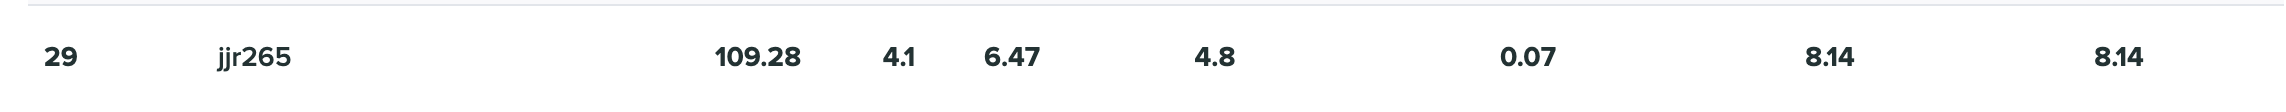

#Appendix
---


## Approximate Projected Point Breakdown

- Q1. Dataset observations (5)
- Q1.1 Implement and discuss the metric(s) (5)
- Q2. Implement your own model (20)
- Q3. Evaluate your own model (10)
- Q4. Implement finetuning (25)
- Q5. Evaluate finetuned model (10)
- Q6. Compare the results (5)
- Q7. Failure analysis (5)
- Q8. Predictions submission (5)
- Code quality (5)
- Page assignment and clarity (5)







## Gradescope Details

Below is a sample `solution.py` code to submit on gradescope. This is also available on Piazza! As it stands, it will not run but this is because the QA model is currently not defined. This is something you will need to write.

```python
import os
import pathlib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import re

import requests
import torch
import transformers

directory = pathlib.Path(__file__).parent.absolute()

drive_path = "https://drive.google.com/file/d/1NbdW7rPuuCd6ij4bR_2yLL8zGvqfyVIb/view?usp=sharing"

gdrive_id = re.search("https://drive.google.com/file/d/(.*)/view\?usp=sharing", drive_path).group(1)
# print(f"GDrive ID: {gdrive_id}")

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


download_file_from_google_drive(gdrive_id, f"{str(directory / 'netid_parameters.zip')}")
print("Parameters downloaded")

proc = subprocess.Popen([f"unzip -o {str(directory / 'netid_parameters.zip')} -d {str(directory)}"], stdout = subprocess.PIPE, shell=True)

(out, error) = proc.communicate()
pathlib.Path(f"{str(directory / 'netid_parameters.zip')}").unlink()
pathlib.Path(f"{str(directory / 'netid_parameters')}").unlink()


get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
model = BertQAModel.from_pretrained(str(directory / "netid_parameters" / "model")).to(get_device())
tokenizer = BertTokenizer.from_pretrained(str(directory / "netid_parameters" / "tokenizer"))

model.eval()
print("Model loaded")


def predict(question, context):
    '''predict uses your PCE model and predicts the answer and answerability

    Takes a `question` string and an `context` string (which contains the
    answer), and identifies the words within the `context` that are the
    answer, and if there is an answer

    :param question: The question to answer
    :type question: str
    :param context: The context in which to search for the answer
    :type context: str
    :return: A pair of (answer, hasAns) that represents the model's prediction
        on the answer and whether this question is answerable
    :rtype: Tuple[str, bool]
    '''
    with torch.no_grad():
        # ======== Tokenize ========
        # Apply the tokenizer to the input text, treating them as a text-pair.
        input_ids = tokenizer.encode(question, context, max_length=512, truncation=True,)

        # Report how long the input sequence is.
        # print('Query has {:,} tokens.\n'.format(len(input_ids)))

        # ======== Set Segment IDs ========
        # Search the input_ids for the first instance of the `[SEP]` token.
        sep_index = input_ids.index(tokenizer.sep_token_id)

        # The number of segment A tokens includes the [SEP] token istelf.
        num_seg_a = sep_index + 1

        # The remainder are segment B.
        num_seg_b = len(input_ids) - num_seg_a

        # Construct the list of 0s and 1s.
        segment_ids = [0]*num_seg_a + [1]*num_seg_b

        # There should be a segment_id for every input token.
        assert len(segment_ids) == len(input_ids)

        # ======== Evaluate ========
        # Run our example question through the model.
        start_scores, end_scores = model(torch.tensor([input_ids]).to(get_device()), # The tokens representing our input text.
                                        token_type_ids=torch.tensor([segment_ids]).to(get_device())) # The segment IDs to differentiate question from context

        # ======== Reconstruct Answer ========
        # Find the tokens with the highest `start` and `end` scores.
        answer_start = torch.argmax(start_scores.cpu())
        answer_end = torch.argmax(end_scores.cpu())

        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        # Start with the first token.
        answer = tokens[answer_start]

        # Select the remaining answer tokens and join them with whitespace.
        for i in range(answer_start + 1, answer_end + 1):
            
            # If it's a subword token, then recombine it with the previous token.
            if tokens[i][0:2] == '##':
                answer += tokens[i][2:]
            
            # Otherwise, add a space then the token.
            else:
                answer += ' ' + tokens[i]

        # print('Answer: "' + answer + '"')

        return answer, True

```
